# Lewis Hamilton v. Top Drivers

![title](images\lewis.jpg)

Lewis Hamilton is a six-time Forumla One World Champion and lightly regarded as the greatest Formula One Driver of all time. He won his first World Driver's Championship with McLaren in 2008 and then moved to Mercedes, where he proceeded to win his 5 remaining titles. The notebook will observe Hamilton in comparison to his competitors. What records and how many does he hold? How did he fare in races compared to other legends? Finally, is the driver or their car that decides success?

In [1]:
# import dependencies

import numpy as np
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import gmaps
from datetime import date
from api_keys import g_key
warnings.filterwarnings("ignore")

In [2]:
#create functions

def calculate_age(born):
        born = datetime.datetime.strptime(born, "%m/%d/%Y").date()
        today = date.today()
        return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def championsInYears(Race_Year, Constructor):
    total = []
    t = 0
    for year in Race_Year:
        winner = versus2.loc[versus2['Race_Year']== year].groupby('Constructor')['Yearly_Points'].sum().sort_values(ascending = False).index[0]
        if winner == Constructor:
            t = t + 1
        total.append(t)
    return total

In [3]:
#read in CSVs

df_races  = pd.read_csv('Resources/races.csv')
df_drivers = pd.read_csv('Resources/drivers.csv',encoding='latin1')
df_constructors = pd.read_csv('Resources/constructors.csv',encoding='latin-1')
df_results = pd.read_csv('Resources/results.csv',encoding='latin-1')

#create a clean data frame (need a driver name column & age - don't calcuate until the end)

#marry the results csv to the driver csv
df_drivers['fullName'] = df_drivers['forename'] +" "+ df_drivers['surname']
results = pd.merge(df_results,df_drivers, on='driverId',how='inner')

#keep only the columns needed from the new data frame and join it to the race data
df1 = results[['raceId','driverId','constructorId','positionOrder','points','dob','nationality','fullName']].copy()
race_data = pd.merge(df1,df_races, on='raceId',how='inner')

#keep only the columns needed from the new data frame and join it to the constructor data
df2 = race_data[['raceId','driverId','constructorId','positionOrder','points','dob','nationality','fullName','year','name']].copy()
constructor_data = pd.merge(df2,df_constructors, on='constructorId',how='inner')


#keep only the columns needed from the new data frame
df3 = constructor_data [['positionOrder','points','dob','nationality_x','fullName','year','name_x','name_y','nationality_y']].copy()

#rename columns - make it pretty
df4 = df3.rename(columns={'positionOrder': 'Position', 
                          'points': 'Points', 
                          'dob' : 'DOB', 
                          'nationality_x':'Driver_Nationality',
                          'fullName':'Driver_Name',
                          'year':'Race_Year',
                          'name_x':'Race_Name',
                          'name_y':'Constructor',
                          'nationality_y':'Constructor_Nationality'})

#filter down to the year 2007 and calculate age
clean_data = df4[df4["Race_Year"] >=2007 ]
clean_data['Age'] = clean_data['DOB'].apply(calculate_age)

#read in the final clean data set        
clean_data.head()

,Position,Points,DOB,Driver_Nationality,Driver_Name,Race_Year,Race_Name,Constructor,Constructor_Nationality,Age
0,1,10.0,1/7/1985,British,Lewis Hamilton,2008,Australian Grand Prix,McLaren,British,35
1,5,4.0,10/19/1981,Finnish,Heikki Kovalainen,2008,Australian Grand Prix,McLaren,British,39
2,5,4.0,1/7/1985,British,Lewis Hamilton,2008,Malaysian Grand Prix,McLaren,British,35
3,3,6.0,10/19/1981,Finnish,Heikki Kovalainen,2008,Malaysian Grand Prix,McLaren,British,39
4,13,0.0,1/7/1985,British,Lewis Hamilton,2008,Bahrain Grand Prix,McLaren,British,35


In [4]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5619 entries, 0 to 11082
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Position                 5619 non-null   int64  
 1   Points                   5619 non-null   float64
 2   DOB                      5619 non-null   object 
 3   Driver_Nationality       5619 non-null   object 
 4   Driver_Name              5619 non-null   object 
 5   Race_Year                5619 non-null   int64  
 6   Race_Name                5619 non-null   object 
 7   Constructor              5619 non-null   object 
 8   Constructor_Nationality  5619 non-null   object 
 9   Age                      5619 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 482.9+ KB


In [5]:
clean_data.shape

(5619, 10)

In [6]:
clean_data.describe()

,Position,Points,Race_Year,Age
count,5619.000000,5619.000000,5619.000000,5619.000000
mean,11.285282,4.155633,2013.399537,34.444029
std,6.293460,6.602785,3.854603,6.541419
min,1.000000,0.000000,2007.000000,20.000000
25%,6.000000,0.000000,2010.000000,30.000000
50%,11.000000,0.000000,2013.000000,34.000000
75%,17.000000,6.000000,2017.000000,39.000000
max,24.000000,50.000000,2020.000000,51.000000


# Data by Nationality

![title](images\nationality.jpg)

How does Lewis Hamilton's sucess contribute to Nationality Data?

From a nationality standpoint, Germany leads in almost all regards. Germany is home turf for most of the world's Grands Prix. German Constructors lead in total points and in total wins. Whereas, British drivers lead in total points and total wins. This difference between Constructor and driver, is caused by Lewis Hamilton.

While the data would suggest that driving a car from a German Constructor like Mercedes would make a driver more successful, Mercedes had not won a world title since 1998. So what we really need to look at, is how successful Mercedes became over time, particularly when Lewis Hamilton joined the team in 2008.

In [7]:
#create dataframes for nationality

#driver nationality
driver_nationality= clean_data
driver_nationality['DriverN_TTL_PTS']=driver_nationality.groupby(by='Driver_Name')['Points'].transform('sum').sort_values()
driver_nationality = driver_nationality.loc[clean_data['Position']==1]
driver_nationality['DriverN_TTL_Wins']=driver_nationality.groupby(by='Driver_Name')['Position'].transform('count').sort_values()
d_nation = driver_nationality.drop_duplicates(subset=['Driver_Name'])
d_nation['fig_name'] = d_nation['Driver_Name'] +" ("+ d_nation['Driver_Nationality']+")"


driver_nation = d_nation [['Driver_Name','Driver_Nationality','DriverN_TTL_PTS','DriverN_TTL_Wins','fig_name']].copy()
driver_nation = driver_nation.sort_values(by='DriverN_TTL_Wins', ascending=False)


driver_nation


,Driver_Name,Driver_Nationality,DriverN_TTL_PTS,DriverN_TTL_Wins,fig_name
0,Lewis Hamilton,British,3687.0,92,Lewis Hamilton (British)
4164,Sebastian Vettel,German,3003.0,53,Sebastian Vettel (German)
8602,Nico Rosberg,German,1590.5,23,Nico Rosberg (German)
39,Fernando Alonso,Spanish,1518.0,17,Fernando Alonso (Spanish)
107,Jenson Button,British,1012.0,14,Jenson Button (British)
4675,Kimi RÃ¤ikkÃ¶nen,Finnish,1515.0,12,Kimi RÃ¤ikkÃ¶nen (Finnish)
7366,Mark Webber,Australian,978.5,9,Mark Webber (Australian)
8801,Valtteri Bottas,Finnish,1468.0,9,Valtteri Bottas (Finnish)
7623,Max Verstappen,Dutch,1110.0,9,Max Verstappen (Dutch)
4678,Felipe Massa,Brazilian,1060.0,9,Felipe Massa (Brazilian)


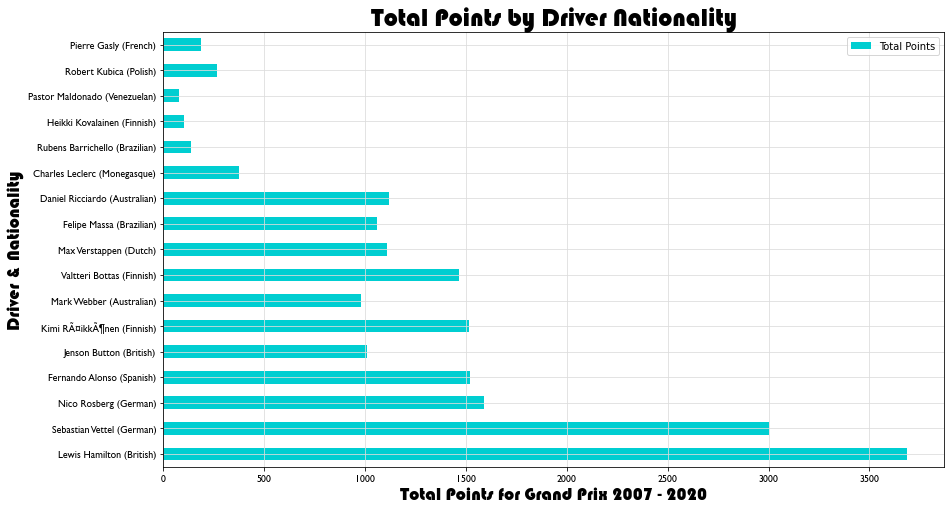

In [8]:
fig1 = driver_nation.plot.barh(x='fig_name', y='DriverN_TTL_PTS', figsize=(14, 8),color='darkturquoise')

plt.title("Total Points by Driver Nationality",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Driver & Nationality',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Total Points for Grand Prix 2007 - 2020',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')


plt.savefig('Visualizations\driver_pts.png')

In [9]:
#constructor nationality
constructor_nationality= clean_data
constructor_nationality['ConN_TTL_PTS']=constructor_nationality.groupby(by='Constructor')['Points'].transform('sum').sort_values()
constructor_nationality = constructor_nationality.loc[clean_data['Position']==1]
constructor_nationality['ConN_TTL_Wins']=constructor_nationality.groupby(by='Constructor')['Position'].transform('count').sort_values()
c_nation = constructor_nationality.drop_duplicates(subset=['Constructor'])
c_nation['fig_name'] = c_nation['Constructor'] +" ("+ c_nation['Constructor_Nationality']+")"


contract_nation = c_nation [['Constructor','Constructor_Nationality','ConN_TTL_PTS','ConN_TTL_Wins','fig_name']].copy()
contract_nation = contract_nation.sort_values(by='ConN_TTL_Wins', ascending=False)

contract_nation

,Constructor,Constructor_Nationality,ConN_TTL_PTS,ConN_TTL_Wins,fig_name
8602,Mercedes,German,5547.0,103,Mercedes (German)
7355,Red Bull,Austrian,4900.5,63,Red Bull (Austrian)
4675,Ferrari,Italian,4703.0,46,Ferrari (Italian)
0,McLaren,British,2536.0,34,McLaren (British)
8488,Brawn,British,172.0,8,Brawn (British)
3388,Renault,French,791.0,2,Renault (French)
10187,Lotus F1,British,706.0,2,Lotus F1 (British)
1746,BMW Sauber,German,272.0,1,BMW Sauber (German)
2062,Williams,British,1054.5,1,Williams (British)
4164,Toro Rosso,Italian,499.0,1,Toro Rosso (Italian)


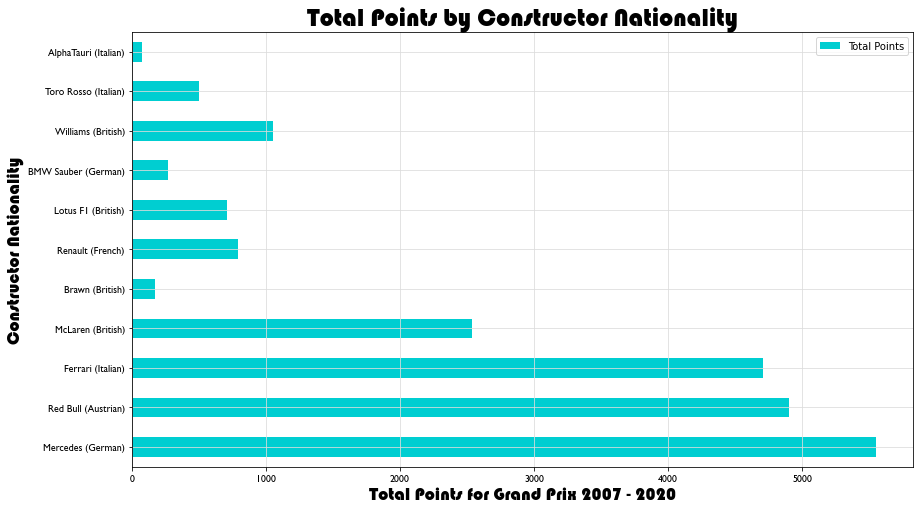

In [10]:
fig2 = contract_nation.plot.barh(x='fig_name', y='ConN_TTL_PTS', figsize=(14, 8),color='darkturquoise')

plt.title("Total Points by Constructor Nationality",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Constructor Nationality',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Total Points for Grand Prix 2007 - 2020',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\constructor_pts.png')

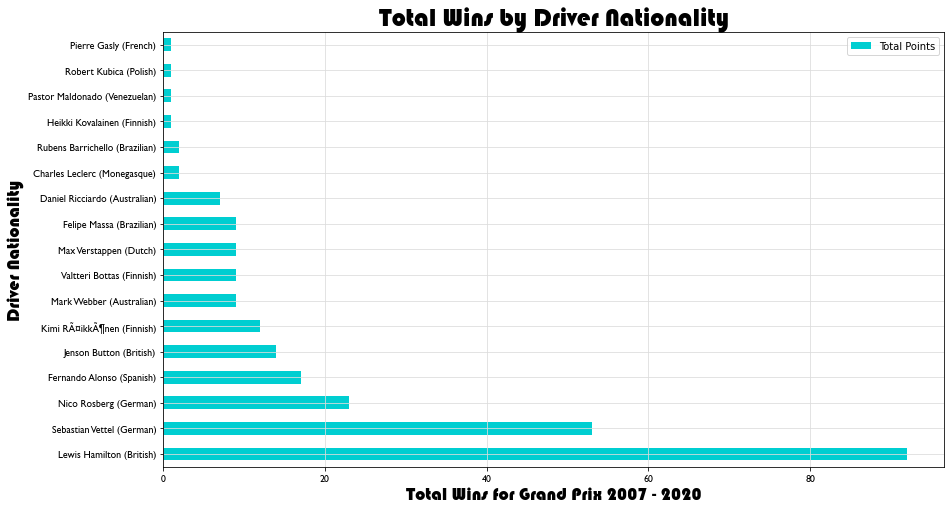

In [11]:
fig3 = driver_nation.plot.barh(x='fig_name', y='DriverN_TTL_Wins', figsize=(14, 8),color='darkturquoise')

plt.title("Total Wins by Driver Nationality",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Driver Nationality',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Total Wins for Grand Prix 2007 - 2020',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\driver_wins.png')

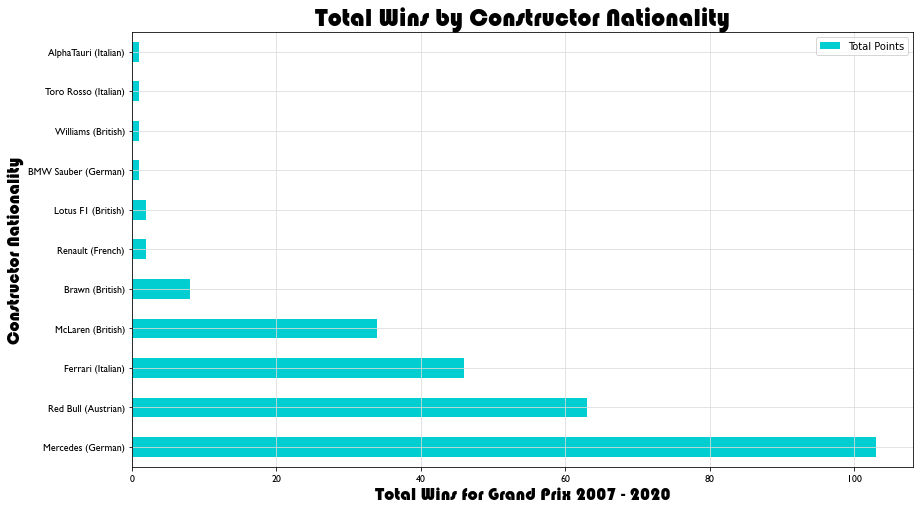

In [12]:
fig4 = contract_nation.plot.barh(x='fig_name', y='ConN_TTL_Wins', figsize=(14, 8),color='darkturquoise')

plt.title("Total Wins by Constructor Nationality",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Constructor Nationality',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Total Wins for Grand Prix 2007 - 2020',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\constructor_wins.png')

In [13]:
#read in race location data to see where the majority of races occur
race_loc = pd.read_csv("Resources/circuits.csv")

# configure heat map
city_locations = race_loc[["lat", "lng",]]
gmaps.configure(api_key=g_key)
fig = gmaps.figure(center=(48.0, 6.0), zoom_level=4)

heat_layer = gmaps.heatmap_layer(city_locations,
                                 dissipating=False,
                                 point_radius=3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Is it Hamilton or Mercedes?

![title](images\hammy.jpg)

The data above suggests that driving a German Car would make you a better driver.

In [14]:
#create a dataframe to analyze Mercedes performance over time

hm = clean_data
hm = hm.loc[hm['Position']==1]

hm['fig_name'] = hm['Driver_Name'] +" ("+ hm ['Driver_Nationality']+")"
mercedes = hm[hm['Constructor']=='Mercedes']
mercedes['Yearly_Points']=mercedes.groupby(by='Race_Year')['Points'].transform('sum').sort_values()
mercedes['Yearly_Wins']=mercedes.groupby(by='Race_Year')['Position'].transform('count').sort_values()

mdf = mercedes[['Race_Year','Yearly_Points','Yearly_Wins','Constructor','fig_name']].copy()

mdf



,Race_Year,Yearly_Points,Yearly_Wins,Constructor,fig_name
8602,2012,25.0,1,Mercedes,Nico Rosberg (German)
8649,2013,75.0,3,Mercedes,Nico Rosberg (German)
8653,2013,75.0,3,Mercedes,Nico Rosberg (German)
8656,2013,75.0,3,Mercedes,Lewis Hamilton (British)
8677,2014,425.0,16,Mercedes,Nico Rosberg (German)
...,...,...,...,...,...
8930,2020,254.0,10,Mercedes,Lewis Hamilton (British)
8934,2020,254.0,10,Mercedes,Lewis Hamilton (British)
8937,2020,254.0,10,Mercedes,Valtteri Bottas (Finnish)
8938,2020,254.0,10,Mercedes,Lewis Hamilton (British)


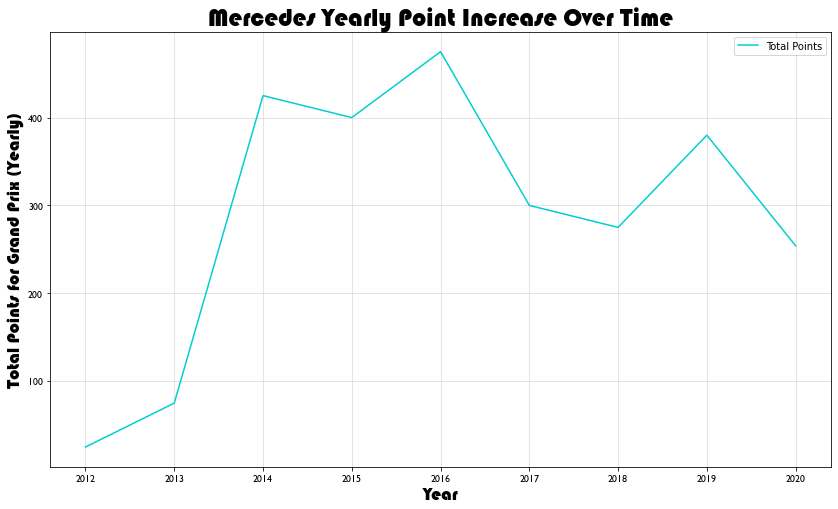

In [15]:
fig5 = mdf.plot(x='Race_Year',y='Yearly_Points', figsize=(14, 8),color='darkturquoise')

plt.title("Mercedes Yearly Point Increase Over Time",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Total Points for Grand Prix (Yearly)',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Year',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\merecdes_pts_timeline.png')

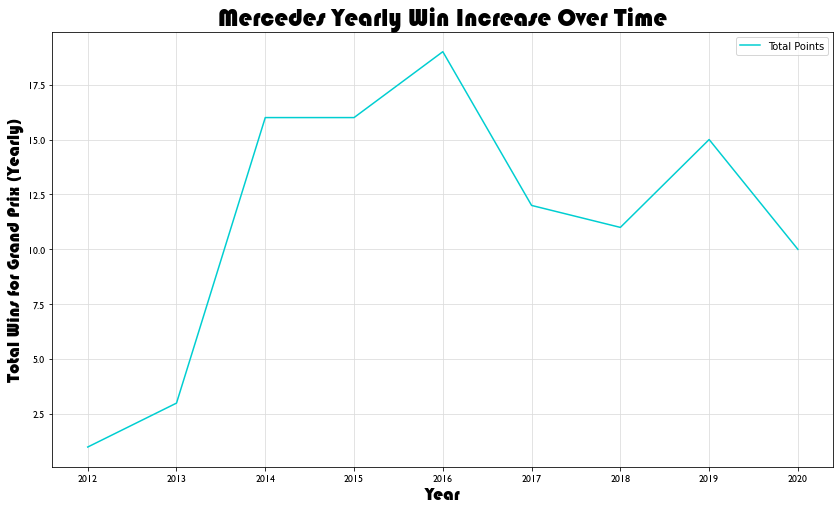

In [16]:
fig6 = mdf.plot(x='Race_Year',y='Yearly_Wins', figsize=(14, 8),color='darkturquoise')

plt.title("Mercedes Yearly Win Increase Over Time",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Total Wins for Grand Prix (Yearly)',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Year',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\merecdes_wins_timeline.png')

In [17]:
#create a dataframe to analyze McLaren performance over time

mclaren = hm[hm['Constructor']=='McLaren']
mclaren['Yearly_Points']=mclaren.groupby(by='Race_Year')['Points'].transform('sum').sort_values()
mclaren['Yearly_Wins']=mclaren.groupby(by='Race_Year')['Position'].transform('count').sort_values()

mcdf = mclaren[['Race_Year','Yearly_Points','Yearly_Wins','Constructor','fig_name']].copy()

mcdf.head()



,Race_Year,Yearly_Points,Yearly_Wins,Constructor,fig_name
0,2008,60.0,6,McLaren,Lewis Hamilton (British)
10,2008,60.0,6,McLaren,Lewis Hamilton (British)
16,2008,60.0,6,McLaren,Lewis Hamilton (British)
18,2008,60.0,6,McLaren,Lewis Hamilton (British)
21,2008,60.0,6,McLaren,Heikki Kovalainen (Finnish)


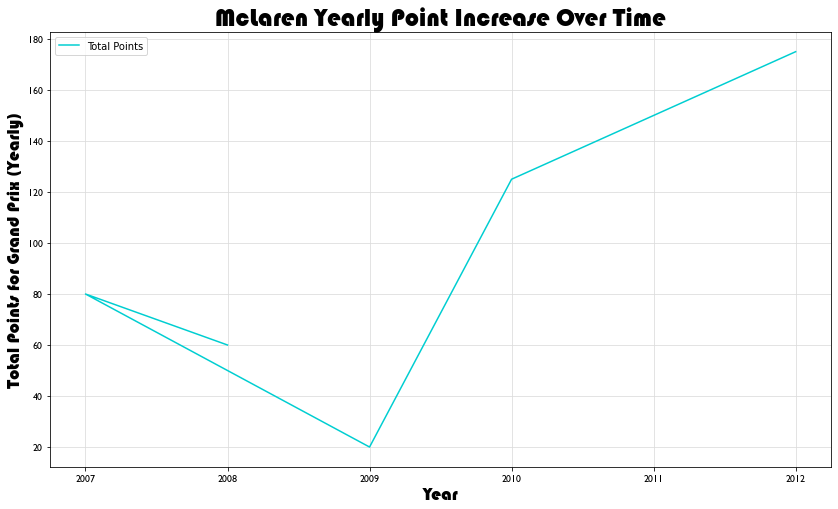

In [18]:
fig7 = mcdf.plot(x='Race_Year',y='Yearly_Points', figsize=(14, 8),color='darkturquoise')

plt.title("McLaren Yearly Point Increase Over Time",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Total Points for Grand Prix (Yearly)',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Year',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\mclaren_pts_timeline.png')

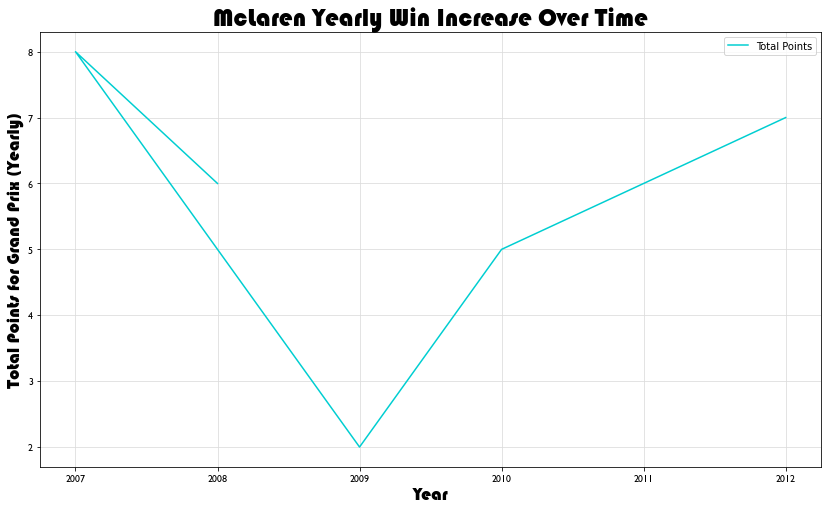

In [19]:
fig7 = mcdf.plot(x='Race_Year',y='Yearly_Wins', figsize=(14, 8),color='darkturquoise')

plt.title("McLaren Yearly Win Increase Over Time",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Total Points for Grand Prix (Yearly)',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Year',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\mclaren_wins_timeline.png')

In [30]:
#create a dataframe to analyze McLaren v. Mercedes performance over time

timeline = hm.query('Constructor== ["McLaren", "Mercedes"]')

timeline['Yearly_Points']=timeline.groupby(by='Race_Year')['Points'].transform('sum').sort_values()
timeline['Yearly_Wins']=timeline.groupby(by='Race_Year')['Position'].transform('count').sort_values()

versus = timeline[['Race_Year','Yearly_Points','Yearly_Wins','Constructor']].copy()


versus2 = pd.DataFrame.drop_duplicates(versus)
versus2



,Race_Year,Yearly_Points,Yearly_Wins,Constructor
0,2008,60.0,6,McLaren
39,2007,80.0,8,McLaren
88,2009,20.0,2,McLaren
107,2010,125.0,5,McLaren
146,2011,150.0,6,McLaren
181,2012,200.0,8,McLaren
8602,2012,200.0,8,Mercedes
8649,2013,75.0,3,Mercedes
8677,2014,425.0,16,Mercedes
8714,2015,400.0,16,Mercedes


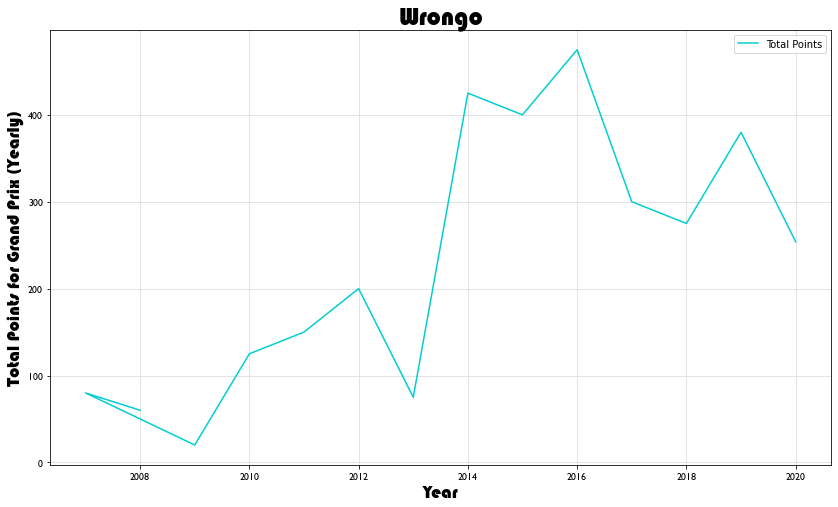

In [32]:
fig8 = versus.plot(x='Race_Year',y='Yearly_Points', figsize=(14, 8),color='darkturquoise')

plt.title("Wrongo",fontsize=25,fontname='bauhaus 93')
plt.ylabel('Total Points for Grand Prix (Yearly)',fontsize = 18, fontname='bauhaus 93')
plt.xlabel('Year',fontsize = 18,fontname='bauhaus 93')
plt.yticks(fontname = "gill sans mt")
plt.xticks(fontname = "gill sans mt")
plt.legend(['Total Points'])
plt.grid(color='gainsboro')

plt.savefig('Visualizations\mercedesvmclaren.png')

ValueError: x and y must have same first dimension, but have shapes (14,) and (9, 2)

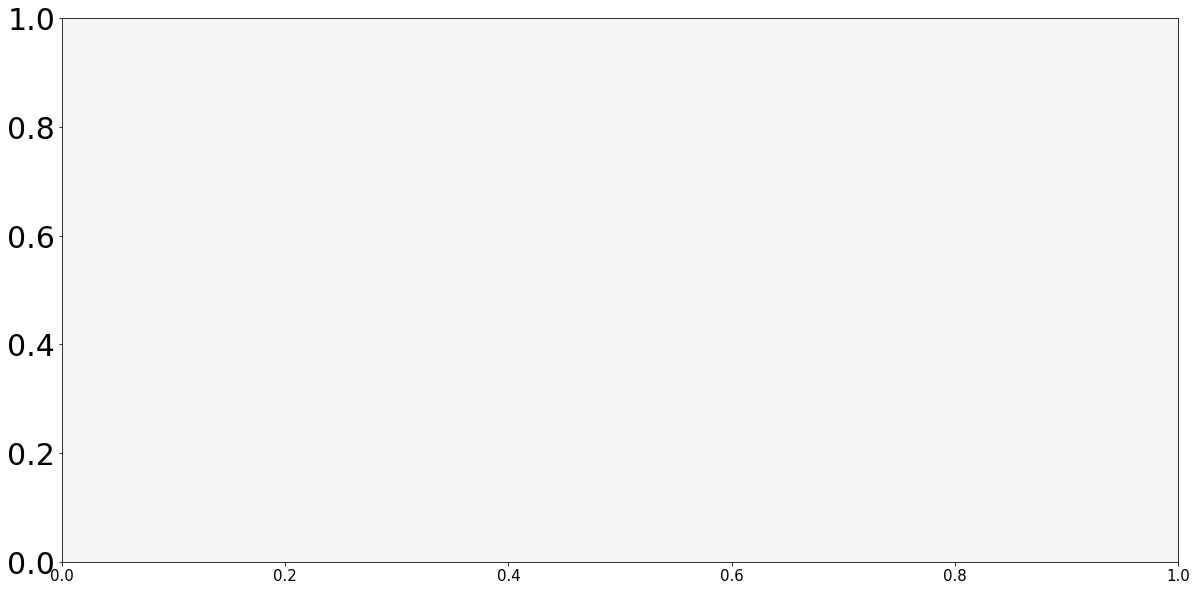

In [28]:
def championsInYears(Race_Year, Constructor):
    total = []
    t = 0
    for year in Race_Year:
        winner = versus2.loc[versus2['Race_Year']== year].groupby('Constructor')['Yearly_Points'].sum().sort_values(ascending = False).index[0]
        if winner == Constructor:
            t = t + 1
        total.append(t)
    return total


mercedes_data = versus2[versus2['Constructor']=='Mercedes']
mclaren_data = versus2[versus2['Constructor']=='McLaren']

mercedes_points = mercedes_data[['Race_Year','Yearly_Points']].copy()
mclaren_points = mclaren_data[['Race_Year','Yearly_Points']].copy()


x = range(2006,2020)
fig,ax = plt.subplots(figsize =(20,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=30)

ax.set_facecolor('whitesmoke')
line1, = ax.plot(x, mercedes_points, label='Mercedes',linewidth=2,color='black')
line2, = ax.plot(x, mclaren_data, label='McLaren' ,linewidth=2, color='magenta')
plt.title("McLaren vs Mercedes Over Hamilton's Career ",fontsize=30)
plt.ylabel('Total',fontsize = 15)
plt.xlabel('Years',fontsize = 15,)
plt.grid()
ax.legend()
plt.show()

In [24]:
mercedes_data = versus2[versus2['Constructor']=='Mercedes']
mclaren_data = versus2[versus2['Constructor']=='McLaren']

mercedes_points = mercedes_data[['Race_Year','Yearly_Points']].copy()
mclaren_points = mclaren_data[['Race_Year','Yearly_Points']].copy()




,Race_Year,Yearly_Points,Yearly_Wins,Constructor
0,2008,60.0,6,McLaren
39,2007,80.0,8,McLaren
88,2009,20.0,2,McLaren
107,2010,125.0,5,McLaren
146,2011,150.0,6,McLaren
181,2012,200.0,8,McLaren
